In [1]:
%matplotlib inline

import os
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import harmonypy
from cnmf import cNMF
import seaborn as sns
import yaml
from scipy.stats import pearsonr
from IPython.display import Image
from matplotlib.pyplot import rc_context

sys.path.append('../../../Code/')
from utils import read_dataset_log, match_columns

# All PBMCs

In [2]:
paths = {'Original': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.h5ad',
 'RNA_Varnorm_Harmony': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.AllPBMC.20240313.RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_HVG_List': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.AllPBMC.20240313.RNA.HVGlist.tsv',
 'Metadata': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.AllPBMC.20240313.metadata.tsv',
 'Raw_Filt_For_cNMF': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.AllPBMC.20240313.FiltForcNMF.h5ad',
 'ADT_MI_Rank': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.AllPBMC.20240313.ADT.TP10K.VarNorm.leidenRNA_MI.tsv',
 'ADT_Varnom_Harmony': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.AllPBMC.20240313.ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_and_ADT_TP10K': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.AllPBMC.20240313.RNA_and_ADT.TP10K.h5ad',
 'RNA_and_ADT_HVG_List': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.AllPBMC.20240313.RNA_and_ADT.HVGlist.tsv',
 'RNA_and_ADT_Varnorm_Harmony_WNN': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.AllPBMC.20240313.RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5mu',
 'RNA_and_ADT_Varnorm_Harmony': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.AllPBMC.20240313.RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'WNN_UMAP': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.AllPBMC.20240313.RNA_and_ADT.TP10K.VarNorm.HVG.HarmonyGeneCorrect.WNN.UMAP.tsv'}

## Run cNMF

In [3]:
cnmfdir = '../../../Data/PerDataset/HaoEtAl'
name = 'HIVVaccine.PBMC'

In [4]:
cnmf_count_fn = paths['RNA_Varnorm_Harmony']
cnmf_tpm_fn = paths['RNA_and_ADT_TP10K']
hvg_fn = paths['RNA_HVG_List']

jname = name
cnmfout = os.path.join(cnmfdir, name, 'log')

Ks = np.arange(10, 60)
n_iter = 20
num_per_node = 10

In [5]:
cnmf_obj = cNMF(output_dir=cnmfdir, name=name)

In [7]:
cnmf_obj.prepare(counts_fn=cnmf_count_fn, components=Ks,
                 n_iter=n_iter, tpm_fn=cnmf_tpm_fn, genes_file=hvg_fn, init='random')

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].


In [8]:
total_workers = int((len(Ks)*n_iter) / num_per_node)
total_workers

100

In [11]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in range(total_workers):
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

bsub -q short -J HIVVaccine.PBMC -o ../../../Data/PerDataset/HaoEtAl/HIVVaccine.PBMC/log/HIVVaccine.PBMC.0.out.txt -e ../../../Data/PerDataset/HaoEtAl/HIVVaccine.PBMC/log/HIVVaccine.PBMC.0.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name HIVVaccine.PBMC --output-dir ../../../Data/PerDataset/HaoEtAl --total-workers 100 --worker-index 0"
Job <469329> is submitted to queue <short>.
bsub -q short -J HIVVaccine.PBMC -o ../../../Data/PerDataset/HaoEtAl/HIVVaccine.PBMC/log/HIVVaccine.PBMC.1.out.txt -e ../../../Data/PerDataset/HaoEtAl/HIVVaccine.PBMC/log/HIVVaccine.PBMC.1.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name HIVVacci

In [12]:
! bjobs | wc -l

102


In [13]:
total_workers = int((len(Ks)*n_iter))
total_workers

1000

In [27]:
import os
def worker_filter(iterable, worker_index, total_workers):
    return (p for i,p in enumerate(iterable) if (i-worker_index)%total_workers==0)

def load_df_from_npz(filename):
    with np.load(filename, allow_pickle=True) as f:
        obj = pd.DataFrame(**f)
    return obj

missing = []
run_params = load_df_from_npz(cnmf_obj.paths['nmf_replicate_parameters'])
for worker_i in range(total_workers):
    jobs_for_this_worker = worker_filter(range(len(run_params)), worker_i, total_workers)
    for idx in jobs_for_this_worker:
        p = run_params.iloc[idx, :]
        outfn = cnmf_obj.paths['iter_spectra'] % (p['n_components'], p['iter'])
        if not os.path.exists(outfn):
            print(worker_i, outfn)
            missing.append(worker_i)

In [29]:
len(missing)

0

In [21]:
# if not os.path.exists(cnmfout): os.mkdir(cnmfout)

# basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
# q = 'medium'
# other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

# for i in missing:
#     cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
#     e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
#     o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
#     bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
#     print(bsub_cmd)
#     !{bsub_cmd}

bsub -q medium -J HIVVaccine.PBMC -o ../../../Data/PerDataset/HaoEtAl/HIVVaccine.PBMC/log/HIVVaccine.PBMC.48.out.txt -e ../../../Data/PerDataset/HaoEtAl/HIVVaccine.PBMC/log/HIVVaccine.PBMC.48.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name HIVVaccine.PBMC --output-dir ../../../Data/PerDataset/HaoEtAl --total-workers 1000 --worker-index 48"
Job <470379> is submitted to queue <medium>.
bsub -q medium -J HIVVaccine.PBMC -o ../../../Data/PerDataset/HaoEtAl/HIVVaccine.PBMC/log/HIVVaccine.PBMC.49.out.txt -e ../../../Data/PerDataset/HaoEtAl/HIVVaccine.PBMC/log/HIVVaccine.PBMC.49.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name

In [ ]:
! bjobs | wc -l

Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
CPU times: user 5h 10min 44s, sys: 8h 23min 30s, total: 13h 34min 15s
Wall time: 42min 52s


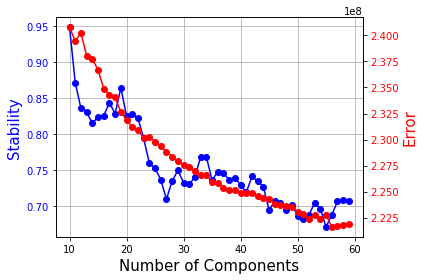

In [31]:
%%time
cnmf_obj.k_selection_plot()

In [6]:
kthresh = {17:0.15, 19:0.15, 21:0.15, 29:0.15, 33:0.15, 34:0.15, 42:0.15, 53:0.15}


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


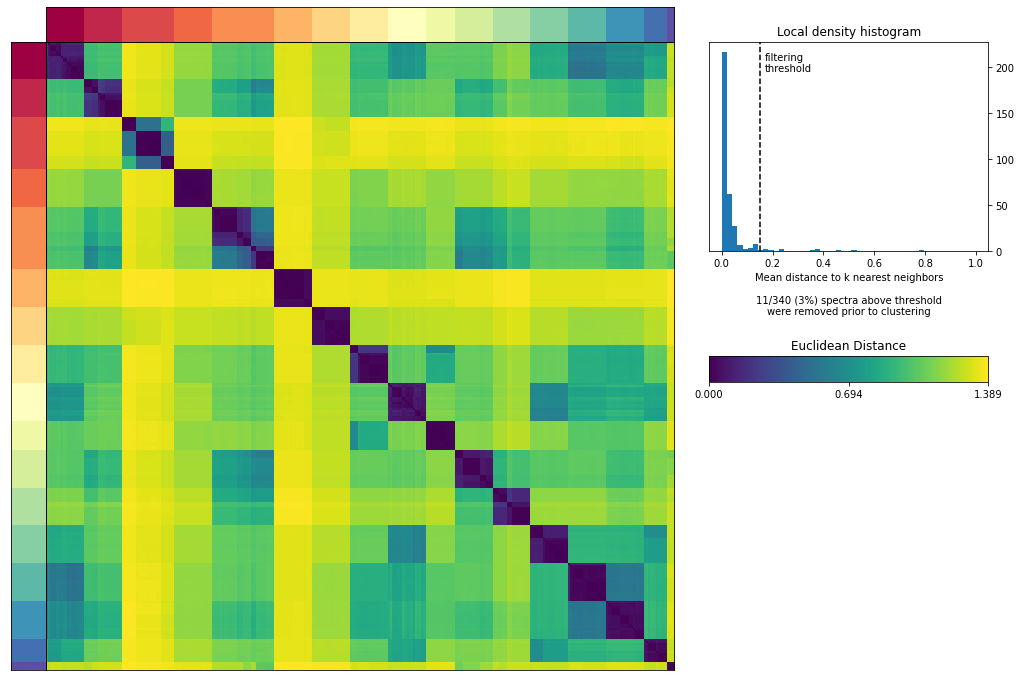

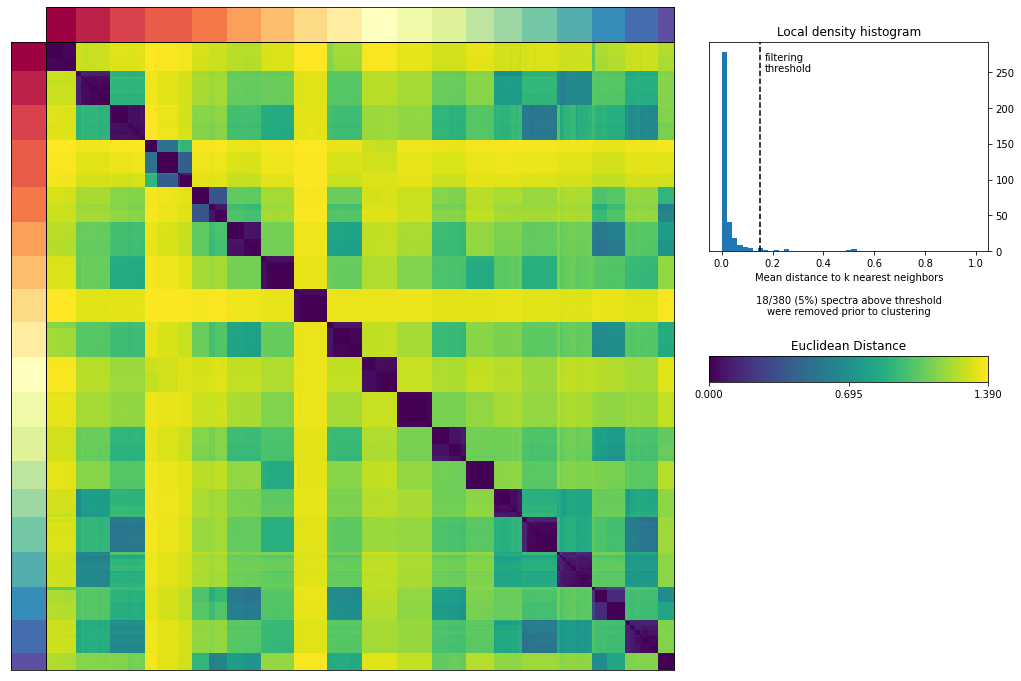

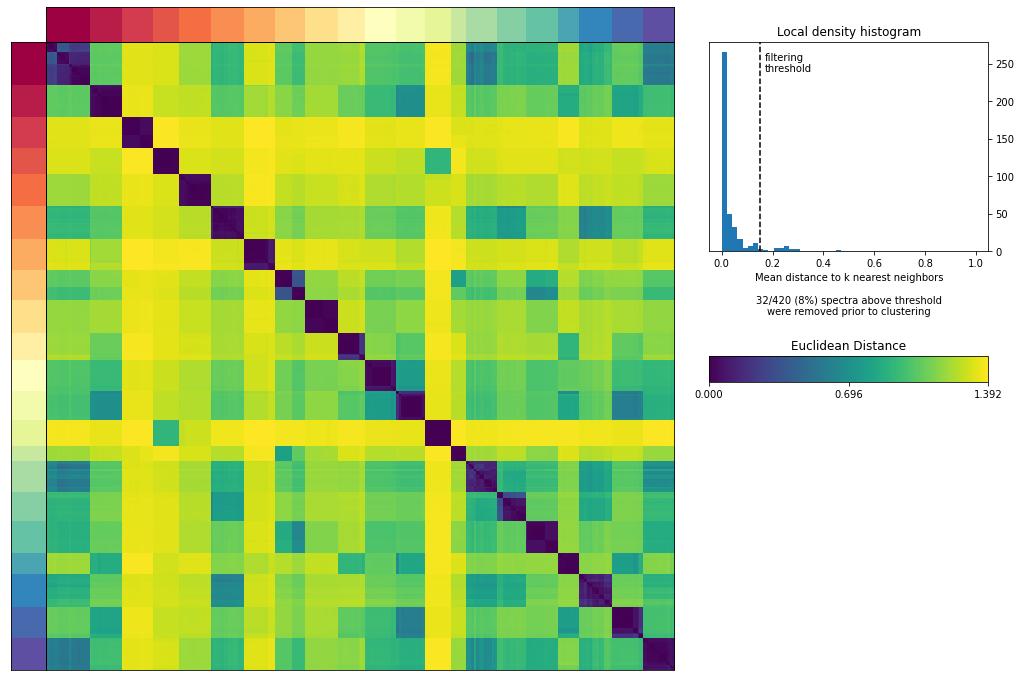

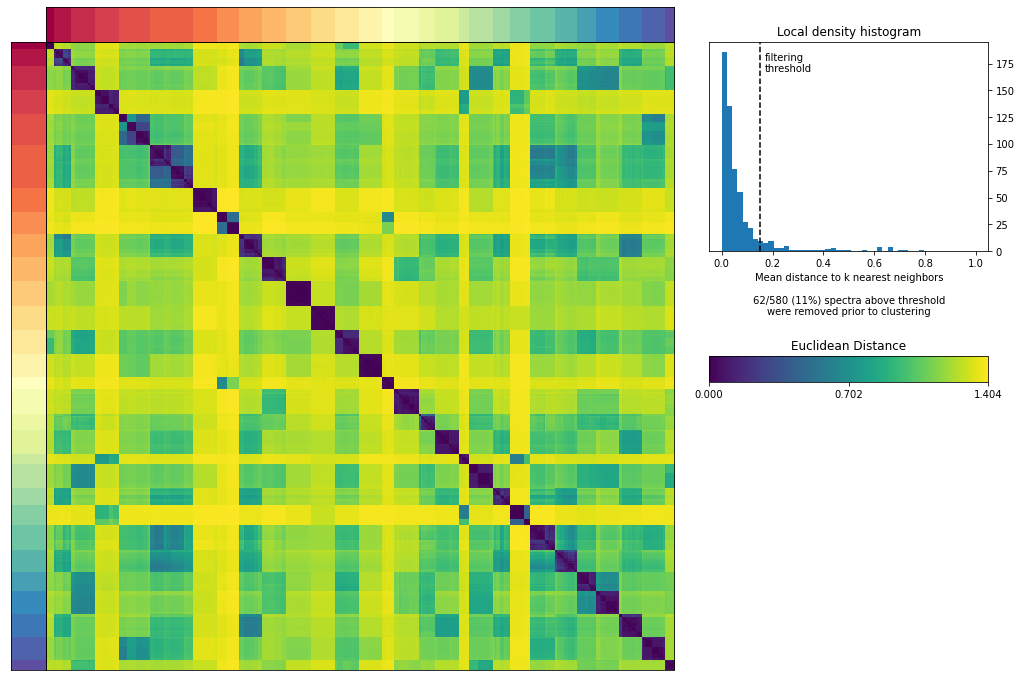

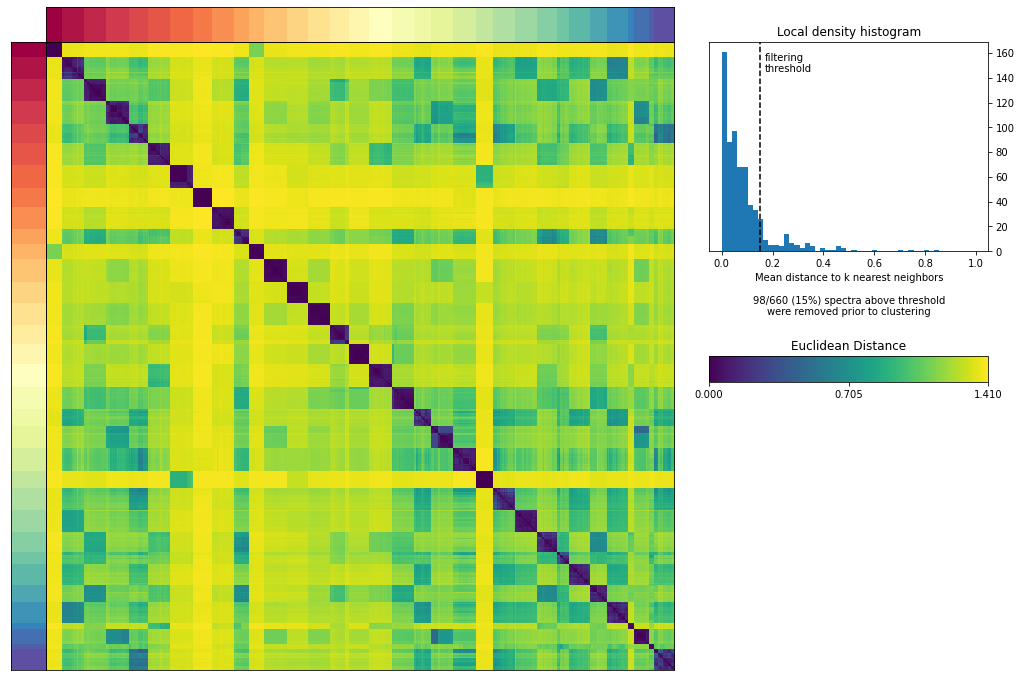

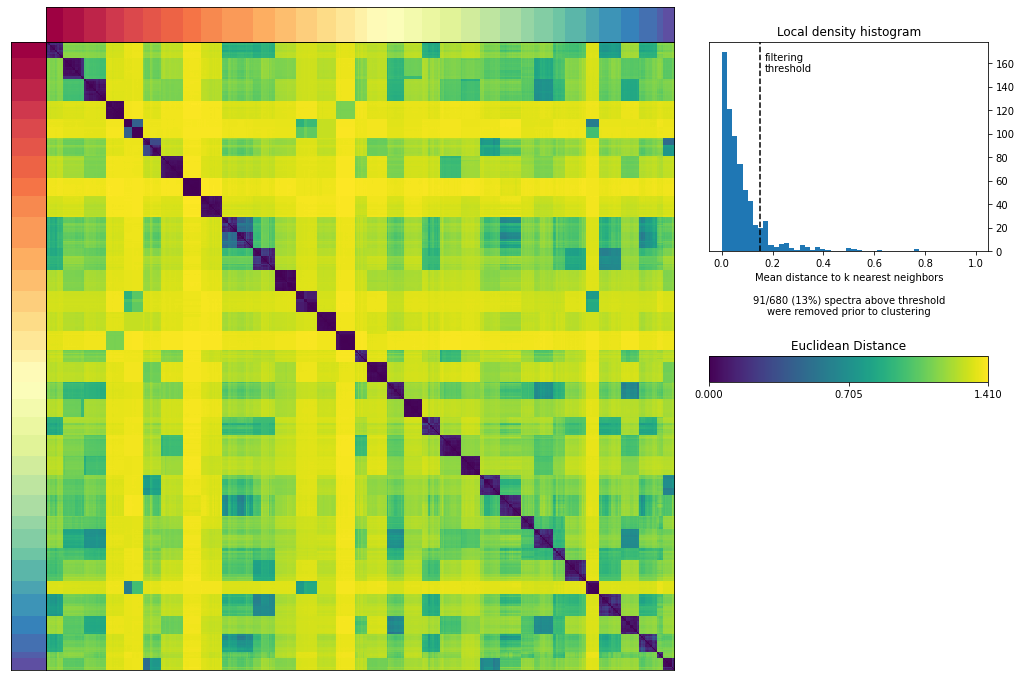

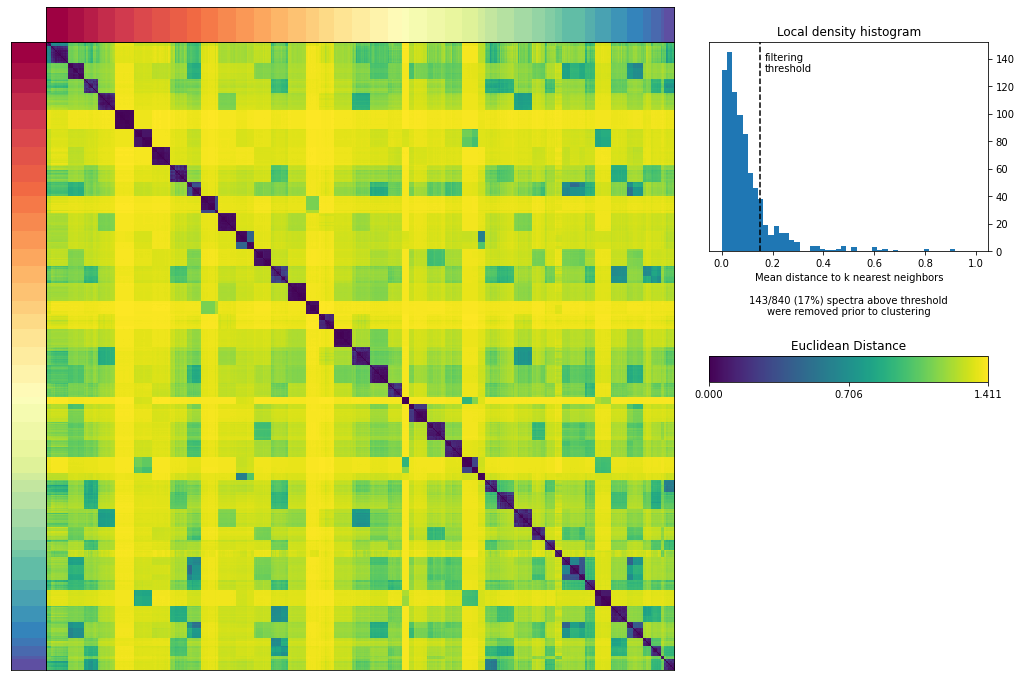

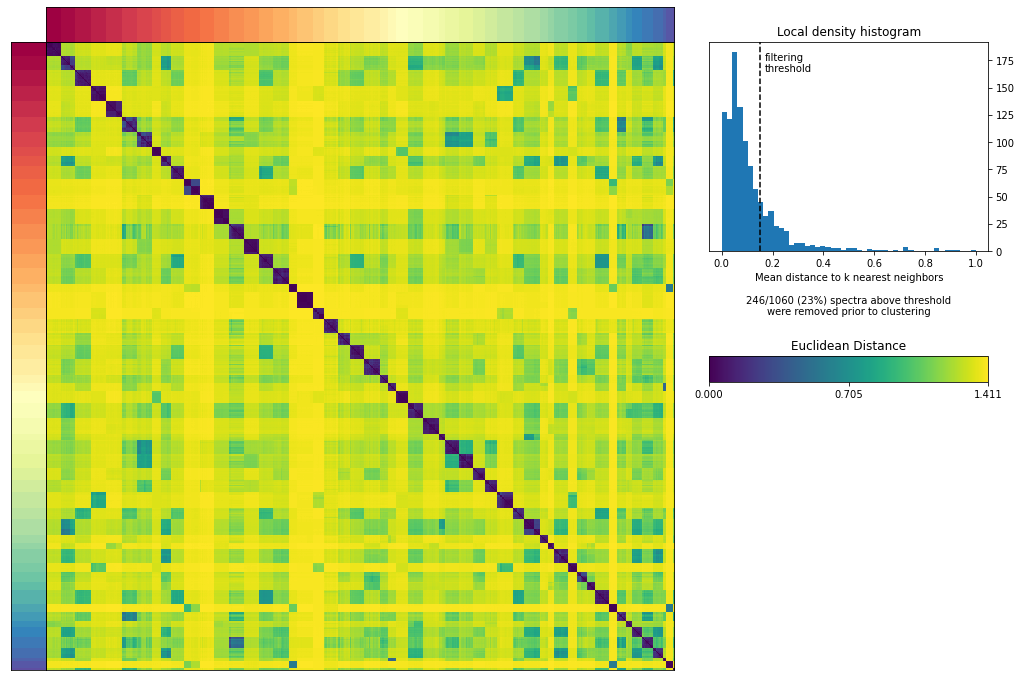

In [33]:
for k in kthresh.keys():
    cnmf_obj.consensus(k=k, density_threshold=kthresh[k])

In [7]:
k=19
(usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=k, density_threshold=kthresh[k])

In [8]:
top_genes.head(20).iloc[:,:15]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,LEF1,MT-CO1,S100A12,AB_CD45RO,PID1,AB_CD16,CD8A,AB_IgD,NFKBIA,CDKN1C,XCL1,IL1B,TNFRSF13B,FCER1A,IFI44L
1,CCR7,MT-CO2,CYP1B1,AB_CD109,LGALS2,SPON2,GZMH,IGHD,ZFP36,HES4,XCL2,CCL4L2,SSPN,ENHO,MX1
2,AB_CD27-1,MT-CO3,PLBD1,AB_CD26-2,AB_CD163,GZMB,AB_CD8a,AB_CD72,G0S2,CKB,GZMK,KCNJ2,AIM2,CLEC10A,IFIT1
3,TCF7,RPS24,RBP7,AB_CD28,IER5L,KLRF1,AB_CD8,IGHM,CCL3,TCF7L2,SPTSSB,CCL3,IGHA1,CD1C,IFIT3
4,TRABD2A,MT-ND4,VNN2,AQP3,SASH1,PRF1,TRGC2,TCL1A,NFKBIZ,SMIM25,DUSP2,CXCL2,IGHG1,PKIB,ISG15
5,AB_CD45RB,MT-ATP6,CDA,AB_CD127,AB_Folate,FGFBP2,CCL5,AB_CD21,NAMPT,MS4A7,CMC1,IL6,JCHAIN,CD1E,OAS3
6,OXNAD1,MT-ND3,PADI4,AB_CD4-1,MARCO,CLIC3,ZNF683,MS4A1,CCL3L1,MS4A4A,KLRC1,DNAAF1,COCH,FLT3,EPSTI1
7,PIK3IP1,TMSB4X,MEGF9,AB_CD4-2,CPVL,AB_CD335,CD8B,AB_CD268,TNF,FCGR3A,AB_CD335,IL1A,IGHA2,CLIC2,IFI44
8,LRRN3,MT-ND1,S100A8,TNFRSF4,AB_CD155,ADGRG1,AB_CD57,CD79A,PPP1R15A,CTSL,AREG,CCL3L1,CPNE5,MRC1,IFI6
9,RCAN3,FAU,QPCT,CCR6,ID1,AKR1C3,NKG7,AB_CD22,CD83,SIGLEC10,IL2RB,CCL4,TEX9,IL1R2,RSAD2


In [9]:
top_genes.head(20).iloc[:,15:]

,16,17,18,19
0,TUBB1,CLEC4C,TYMS,NPR3
1,GP9,LILRA4,MKI67,CD34
2,CAVIN2,SCT,SPC25,SMIM24
3,PF4,LRRC26,ASPM,LINC02573
4,GNG11,EPHB1,TOP2A,HTR1F
5,PPBP,SERPINF1,BIRC5,MYCN
6,CMTM5,LINC00996,RRM2,EMID1
7,PRKAR2B,SCN9A,DLGAP5,CPA3
8,SPARC,LAMP5,PCLAF,AVP
9,TMEM40,ASIP,GTSE1,CRHBP


## Compare with original TCATs

In [10]:
metagepinfo = read_dataset_log(tabname='cGEP Paths').loc[0,:]
gepname = read_dataset_log(tabname='cGEP_Name')
rename_map = dict(zip(gepname['cGep_Name'], gepname['Short_Name']))
tcat_spectra_all = pd.read_csv(metagepinfo.loc['scores_spectra'], sep='\t', index_col=0).T
tcat_spectra_all = tcat_spectra_all.rename(columns=rename_map)

In [11]:
k=19
(usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=k, density_threshold=kthresh[k])
overlap_genes = list(set(spectra_scores.index).intersection(tcat_spectra_all.index))
mapping, unmatched, R = match_columns(tcat_spectra_all.loc[overlap_genes, :], spectra_scores.loc[overlap_genes, :])
mapping

,Y_columns,X_columns,R
731,15,ISG,0.827627
897,18,CellCycle-Late-S,0.807042
24,1,CD4-Naive,0.677233
268,6,Cytotoxic,0.620715
96,2,CD172a/MERTK,0.577657
789,16,Doublet-Platelet,0.565873
339,7,Poor-Quality,0.506986
182,4,Th17-Resting,0.482966
401,8,Doublet-Bcell,0.477997
434,9,Doublet-Myeloid,0.454798


In [12]:
(mapping['R']>.55).value_counts()

False    13
True      6
Name: R, dtype: int64

In [13]:
k=34
(usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=k, density_threshold=kthresh[k])
overlap_genes = list(set(spectra_scores.index).intersection(tcat_spectra_all.index))
mapping, unmatched, R = match_columns(tcat_spectra_all.loc[overlap_genes, :], spectra_scores.loc[overlap_genes, :])
(mapping['R']>.55).value_counts()

False    22
True     12
Name: R, dtype: int64

In [14]:
mapping

,Y_columns,X_columns,R
1411,28,CellCycle-S,0.911096
1612,32,CellCycle-G2M,0.883105
1095,22,ISG,0.844212
1721,34,Doublet-RBC,0.784227
651,13,Poor-Quality,0.749308
320,7,Cytotoxic,0.705944
53,2,Translation,0.695787
1205,24,Doublet-Platelet,0.650067
740,15,MAIT,0.607352
542,11,CD8-EM,0.582126


In [27]:
k=53
(usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=k, density_threshold=kthresh[k])
overlap_genes = list(set(spectra_scores.index).intersection(tcat_spectra_all.index))
mapping, unmatched, R = match_columns(spectra_scores.loc[overlap_genes, :], tcat_spectra_all.loc[overlap_genes, :])
(mapping['R']>.55).value_counts()


False    33
True     19
Name: R, dtype: int64

In [28]:
mapping

,Y_columns,X_columns,R
407,CellCycle-S,37,0.924492
733,CellCycle-Late-S,45,0.881954
182,ISG,24,0.857085
41,CellCycle-G2M,42,0.850519
1240,IEG2,22,0.825362
55,Translation,3,0.789564
313,Doublet-RBC,49,0.784806
1443,Poor-Quality,13,0.769728
433,Cytotoxic,10,0.747697
654,MAIT,19,0.695449


# K=53

In [29]:
cnmfdir = '../../../Data/PerDataset/HaoEtAl'
name = 'HIVVaccine.PBMC.Iter200'

In [35]:
cnmf_count_fn = paths['RNA_Varnorm_Harmony']
cnmf_tpm_fn = paths['RNA_and_ADT_TP10K']
hvg_fn = paths['RNA_HVG_List']

jname = name
cnmfout = os.path.join(cnmfdir, name, 'log')

Ks = np.arange(53, 54)
n_iter = 200
num_per_node = 4

In [37]:
total_workers = int((len(Ks)*n_iter) / num_per_node)
total_workers

50

In [38]:
cnmf_obj = cNMF(output_dir=cnmfdir, name=name)

In [39]:
cnmf_obj.prepare(counts_fn=cnmf_count_fn, components=Ks,
                 n_iter=n_iter, tpm_fn=cnmf_tpm_fn, genes_file=hvg_fn, init='random')

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].


In [40]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in range(total_workers):
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

bsub -q short -J HIVVaccine.PBMC.Iter200 -o ../../../Data/PerDataset/HaoEtAl/HIVVaccine.PBMC.Iter200/log/HIVVaccine.PBMC.Iter200.0.out.txt -e ../../../Data/PerDataset/HaoEtAl/HIVVaccine.PBMC.Iter200/log/HIVVaccine.PBMC.Iter200.0.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name HIVVaccine.PBMC.Iter200 --output-dir ../../../Data/PerDataset/HaoEtAl --total-workers 50 --worker-index 0"
Job <755898> is submitted to queue <short>.
bsub -q short -J HIVVaccine.PBMC.Iter200 -o ../../../Data/PerDataset/HaoEtAl/HIVVaccine.PBMC.Iter200/log/HIVVaccine.PBMC.Iter200.1.out.txt -e ../../../Data/PerDataset/HaoEtAl/HIVVaccine.PBMC.Iter200/log/HIVVaccine.PBMC.Iter200.1.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn00

In [63]:
! bjobs

No unfinished job found


In [64]:
! bjobs | wc -l

No unfinished job found
0


In [41]:
total_workers = int((len(Ks)*n_iter))
total_workers

200

In [54]:
import os
def worker_filter(iterable, worker_index, total_workers):
    return (p for i,p in enumerate(iterable) if (i-worker_index)%total_workers==0)

def load_df_from_npz(filename):
    with np.load(filename, allow_pickle=True) as f:
        obj = pd.DataFrame(**f)
    return obj

missing = []
run_params = load_df_from_npz(cnmf_obj.paths['nmf_replicate_parameters'])
for worker_i in range(total_workers):
    jobs_for_this_worker = worker_filter(range(len(run_params)), worker_i, total_workers)
    for idx in jobs_for_this_worker:
        p = run_params.iloc[idx, :]
        outfn = cnmf_obj.paths['iter_spectra'] % (p['n_components'], p['iter'])
        if not os.path.exists(outfn):
            #print(worker_i, outfn)
            missing.append(worker_i)
            
len(missing)

0

In [55]:
missing

[]

In [52]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'medium'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in missing:
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

bsub -q medium -J HIVVaccine.PBMC.Iter200 -o ../../../Data/PerDataset/HaoEtAl/HIVVaccine.PBMC.Iter200/log/HIVVaccine.PBMC.Iter200.74.out.txt -e ../../../Data/PerDataset/HaoEtAl/HIVVaccine.PBMC.Iter200/log/HIVVaccine.PBMC.Iter200.74.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name HIVVaccine.PBMC.Iter200 --output-dir ../../../Data/PerDataset/HaoEtAl --total-workers 200 --worker-index 74"
Job <790335> is submitted to queue <medium>.
bsub -q medium -J HIVVaccine.PBMC.Iter200 -o ../../../Data/PerDataset/HaoEtAl/HIVVaccine.PBMC.Iter200/log/HIVVaccine.PBMC.Iter200.85.out.txt -e ../../../Data/PerDataset/HaoEtAl/HIVVaccine.PBMC.Iter200/log/HIVVaccine.PBMC.Iter200.85.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hn

In [44]:
total_workers = int((len(Ks)*n_iter))
total_workers

200

## Look at the results for K=53 with 200 iterations

In [56]:
cnmf_obj.combine(skip_missing_files=False)

Combining factorizations for k=53.


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


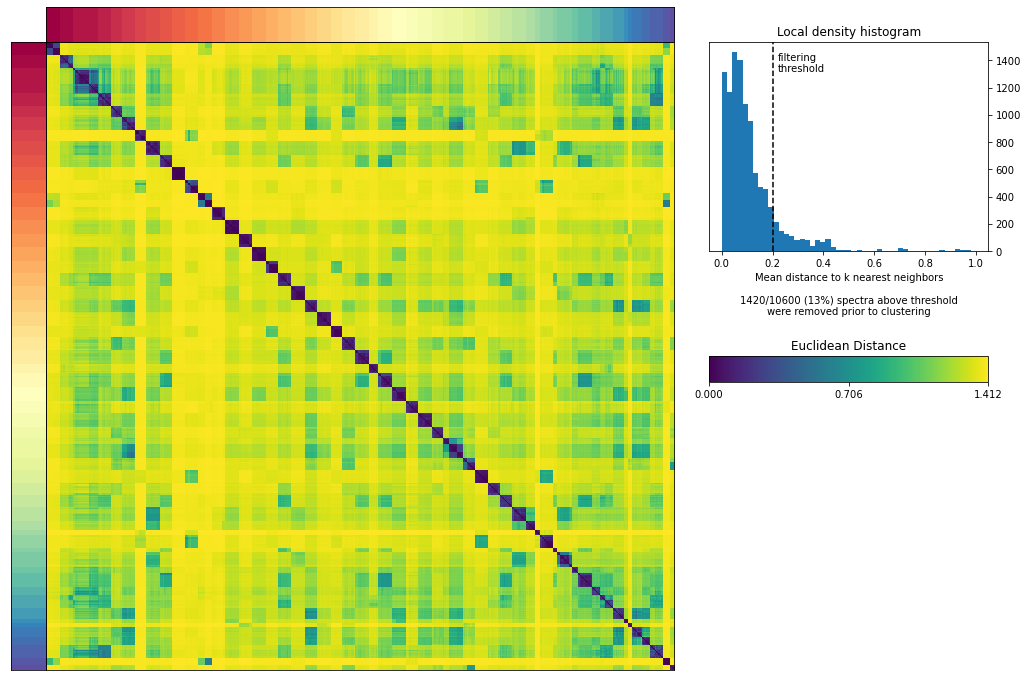

In [57]:
cnmf_obj.consensus(k=53, density_threshold=0.2)

In [59]:
(usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=53, density_threshold=0.2)
# overlap_genes = list(set(spectra_scores.index).intersection(tcat_spectra_all.index))
# mapping, unmatched, R = match_columns(tcat_spectra_all.loc[overlap_genes, :], spectra_scores.loc[overlap_genes, :])
# R_for_plot = R.loc[list(mapping['X_columns']) + unmatched, mapping['Y_columns']]
# rename_dict = dict(zip(mapping['Y_columns'], mapping['X_columns']))

# fig,ax = plt.subplots(1,1, figsize=(8,8), dpi=200)
# sns.heatmap(R_for_plot, ax=ax)
# ax.set_xticks(np.arange(R_for_plot.shape[1])+0.5)
# ax.set_yticks(np.arange(R_for_plot.shape[0])+0.5)
# ax.set_xticklabels(R_for_plot.columns, fontsize=4)
# _ = ax.set_yticklabels(R_for_plot.index, fontsize=4)

In [62]:
overlap_genes = list(set(spectra_scores.index).intersection(tcat_spectra_all.index))
mapping, unmatched, R = match_columns(spectra_scores.loc[overlap_genes, :], tcat_spectra_all.loc[overlap_genes, :])

In [78]:
dict(zip(usage.columns, usage.columns.astype('str')))

{1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: '10',
 11: '11',
 12: '12',
 13: '13',
 14: '14',
 15: '15',
 16: '16',
 17: '17',
 18: '18',
 19: '19',
 20: '20',
 21: '21',
 22: '22',
 23: '23',
 24: '24',
 25: '25',
 26: '26',
 27: '27',
 28: '28',
 29: '29',
 30: '30',
 31: '31',
 32: '32',
 33: '33',
 34: '34',
 35: '35',
 36: '36',
 37: '37',
 38: '38',
 39: '39',
 40: '40',
 41: '41',
 42: '42',
 43: '43',
 44: '44',
 45: '45',
 46: '46',
 47: '47',
 48: '48',
 49: '49',
 50: '50',
 51: '51',
 52: '52',
 53: '53'}

In [83]:
# gep_labels = dict(zip(usage.columns, usage.columns.astype('str')))

In [84]:
gep_labels = {1: 'Translation',
 2: 'CD4-Naive',
 3: 'CD4-Memory', ## Unclear if EM/CM
 4: '4',
 5: '5',
 6: '6',
 7: 'Cytotoxic',
 8: '8',
 9: 'CD8-Naive',
 10: 'Poor-Quality',
 11: '11',
 12: 'Cytoskeleton',
 13: '13',
 14: '14',
 15: '15',
 16: 'CD8-EM', ###?
 17: '17',
 18: 'IEG',
 19: '19',
 20: 'MAIT',
 21: '21',
 22: '22',
 23: '23',
 24: '24',
 25: 'ISG',
 26: '26',
 27: '27',
 28: '28',
 29: '29',
 30: '30',
 31: '31', ### Platelet possibly
 32: '32',
 33: 'Treg',
 34: '34',
 35: '35',
 36: '36',
 37: 'CellCycle-S',
 38: '38',
 39: 'Th2',
 40: '40',
 41: 'gdT',
 42: '42',
 43: '43',
 44: 'CellCycle-G2M',
 45: 'CellCycle-Late-S',
 46: '46',
 47: 'Mast',
 48: '48',
 49: 'Doublet-RBC',
 50: '50',
 51: '51',
 52: 'B',
 53: '53'}


{1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: '10',
 11: '11',
 12: '12',
 13: '13',
 14: '14',
 15: '15',
 16: '16',
 17: '17',
 18: '18',
 19: '19',
 20: '20',
 21: '21',
 22: '22',
 23: '23',
 24: '24',
 25: '25',
 26: '26',
 27: '27',
 28: '28',
 29: '29',
 30: '30',
 31: '31',
 32: '32',
 33: '33',
 34: '34',
 35: '35',
 36: '36',
 37: '37',
 38: '38',
 39: '39',
 40: '40',
 41: '41',
 42: '42',
 43: '43',
 44: '44',
 45: '45',
 46: '46',
 47: '47',
 48: '48',
 49: '49',
 50: '50',
 51: '51',
 52: '52',
 53: '53'}

In [72]:
top_genes.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1,RPS24,EEF1A1,RPL26,RPLP1,RPS14,RPS2,RPS11,RPS8,UBA52,TPT1,RPL10,RPS9,RPS23,RPL7,RPL37A,RPL6,RPL13,RPL7A,RPL39,RPL8
2,CCR7,FHIT,IL6ST,LEF1,AB_CD109,TSHZ2,AB_CD4-2,AB_CD4-1,TRABD2A,TCF7,ADTRP,AB_CD307e,MAL,LINC00861,TRAT1,AB_CD278,CAMK4,PIK3IP1,AB_GP130,CHRM3-AS2
3,AB_CD45RO,TNFRSF4,AQP3,TTC39C-AS1,CCR6,AB_CD109,PTPN13,AB_CD4-2,MAF,AB_CD127,NPDC1,AB_CD4-1,ITGB1,RORA,AB_CD28,PDE4D,AB_CD307e,AB_CD209,TRADD,AB_CD95
4,P2RY13,CYP27A1,ALDH1A1,CLEC4A,KCNE3,OLIG1,CD1D,DSC2,IL13RA1,PTAFR,ADGRE2,PDK4,LGALS2,DUSP6,CCR2,TMEM176A,RASSF4,FCGR2A,ATP6V1B2,LRP1
5,S100A6,S100A11,S100A8,S100A9,LYZ,FTH1,FTL,CTSS,TSPO,S100A4,FOS,AIF1,CYBA,TYROBP,MNDA,CST3,NEAT1,FCN1,SRGN,SAT1
6,SPON2,AKR1C3,AB_CD16,CLIC3,KLRF1,AB_CD38-2,AB_CD38-1,GZMB,PRF1,FGFBP2,AB_CD335,IGFBP7,AB_CD337,MYOM2,AB_CD122,SH2D1B,ADGRG1,CX3CR1,CD247,CHST2
7,GZMH,ZNF683,FGFBP2,ITGB1,CD8A,TRGC2,GNLY,NKG7,GZMB,ADGRG1,PRSS23,AB_CD271,CCL5,CST7,TGFBR3,AB_CD57,AB_CD43,C1orf21,PATL2,AB_CD8a
8,PADI4,CYP1B1,PLBD1,RBP7,MARC1,QPCT,F5,MCEMP1,S100A12,VNN2,CDA,VNN3,DYSF,BST1,MEGF9,VNN1,ITGAM,PGD,LRRK2,CR1
9,LINC02446,CD8B,AB_CD8,AB_CD8a,NELL2,CD8A,S100B,AB_CD314,PASK,AB_CD73,CPA5,THEMIS,PDE3B,LRRN3,OXNAD1,CRTAM,DSEL,NUCB2,CCR7,LEF1
10,MT-ND4L,MT-ND1,MT-ND5,UTRN,MT-CO1,MTRNR2L12,MT-ND2,MT-ND4,GOLGB1,MT-CYB,RNF213,MT-CO3,MT-CO2,MT-ND3,MT-ATP6,PARP14,MTRNR2L8,MT-ND6,XIST,ITGA4
